# Predicting CO2 Emissions in Rwanda

Link: https://www.kaggle.com/competitions/playground-series-s3e20/

The ability to accurately monitor carbon emissions is a critical step in the fight against climate change. Precise carbon readings allow researchers and governments to understand the sources and patterns of carbon mass output. While Europe and North America have extensive systems in place to monitor carbon emissions on the ground, there are few available in Africa.

The objective of this challenge is to create a machine learning models using open-source CO2 emissions data from Sentinel-5P satellite observations to predict future carbon emissions.

These solutions may help enable governments, and other actors to estimate carbon emission levels across Africa, even in places where on-the-ground monitoring is not possible.
Acknowledgements

We acknowledge Carbon Monitor for the use of the GRACED dataset, and special thanks Darius Moruri from Zindi for his work in preparing the dataset and starter notebooks.

## Dataset Description

The objective of this challenge is to create machine learning models that use open-source emissions data (from Sentinel-5P satellite observations) to predict carbon emissions.

Approximately 497 unique locations were selected from multiple areas in Rwanda, with a distribution around farm lands, cities and power plants. The data for this competition is split by time; the years 2019 - 2021 are included in the training data, and your task is to predict the CO2 emissions data for 2022 through November.

Seven main features were extracted weekly from Sentinel-5P from January 2019 to November 2022. Each feature (Sulphur Dioxide, Carbon Monoxide, etc) contain sub features such as column_number_density which is the vertical column density at ground level, calculated using the DOAS technique. You can read more about each feature in the below links, including how they are measured and variable definitions. You are given the values of these features in the test set and your goal to predict CO2 emissions using time information as well as these features.

   * Sulphur Dioxide - COPERNICUS/S5P/NRTI/L3_SO2
   * Carbon Monoxide - COPERNICUS/S5P/NRTI/L3_CO
   * Nitrogen Dioxide - COPERNICUS/S5P/NRTI/L3_NO2
   * Formaldehyde - COPERNICUS/S5P/NRTI/L3_HCHO
   * UV Aerosol Index - COPERNICUS/S5P/NRTI/L3_AER_AI
   * Ozone - COPERNICUS/S5P/NRTI/L3_O3
   * Cloud - COPERNICUS/S5P/OFFL/L3_CLOUD


In [1]:
#! pip install -qU pytorch-forecasting

In [2]:
import pickle
import os
import re
import time
from typing import List, Optional, Tuple
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from IPython.display import display

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_colwidth', 3000)
pd.set_option('display.max_columns', None)


# Read data

In [3]:
df = pd.read_csv("data/train.csv")    
df["emission_log"] = np.log(df["emission"])
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['week_no'].astype(str) + '-1', format='%Y-%W-%w') 
df.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,emission_log,date
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,-130.050797,35.874496,-0.000027,0.035370,1589.024536,4061.098145,829530.500000,71.111977,52.775928,-149.875565,25.965214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000117,0.863230,0.000038,0.255668,35.874496,-130.050797,50.843559,-98.593887,-1.280761,829864.546875,-12.628979,35.632416,-138.786446,30.752128,0.115927,2.506609,0.295663,225.731144,0.595473,-12.628979,35.632416,-138.786446,30.752128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.595473,53534.732422,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994,1.322021,2018-12-31
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,-140.874435,28.965133,0.000012,0.036526,1772.574405,1869.040414,829787.287130,-1.019594,38.982368,-140.158048,29.562000,0.000047,1.639765e-05,0.00003,0.000093,7311.869141,-1.935386,0.067038,829859.960368,5.471037,35.265195,-138.343908,30.054262,0.000170,1.172826,0.000143,0.200754,29.071781,-141.814827,43.050213,4.678839,-1.548119,829747.856973,16.152492,43.485327,-142.786141,28.573627,0.116775,2.657704,0.315733,226.172170,0.175166,24.464335,42.596541,-143.097868,28.213655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.213608,63790.296241,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176,1.392569,2019-01-07
2,ID_-0.510_29.290_2019_02,

In [4]:
# The test data consists of records from 2022 for 487 different localizations
test_df = pd.read_csv("data/test.csv")    
test_df.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-0.510_29.290_2022_00,-0.51,29.29,2022,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.561522,829937.000000,-100.113785,33.696957,-133.047562,33.779572,0.112175,2.374888,0.269846,227.193100,0.485340,-100.113785,33.696957,-133.047562,33.779572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.485129,36022.027344,8472.313477,41047.937500,7472.313477,7.935617,0.240773,-100.113792,33.697044,-133.047546,33.779583
1,ID_-0.510_29.290_2022_01,-0.51,29.29,2022,1,0.000456,0.691164,0.000316,0.000000,76.239196,15.600607,-140.529848,28.896124,0.000157,0.037641,1688.656342,2814.309683,829652.957598,26.072167,25.189549,-142.612636,28.318923,0.000048,1.117653e-05,0.000037,0.000093,7311.869141,-1.416309,0.036769,829736.125000,76.239196,15.600607,-140.529848,28.896124,0.000123,0.957096,0.000058,0.000000,28.896124,-140.529848,15.600607,76.239196,-0.823662,829753.051343,-0.009998,34.745542,-139.171039,30.405075,0.112643,2.537305,0.290184,228.489219,0.515679,-0.009998,34.745542,-139.171039,30.405075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.711262,48539.737242,6476.147323,54915.708579,5476.147161,11.448437,0.293119,-30.510319,42.402593,-138.632822,31.012380
2,ID_-0.510_29.290_2022_02,-0.51,29.29,2022,2,0.000161,0.605107,0.000106,0.079870,-42.055341,39.889060,-136.908976,30.054682,0.000053,0.037795,2629.692089,3233.654973,829589.971617,14.881259,40.833582,-143.949340,26.760219,0.000055,1.679787e-05,0.000038,0.000109,8

# Data overview

In [5]:
overview_train = df.groupby(["latitude", "longitude"])["ID_LAT_LON_YEAR_WEEK"].count()
overview_test = test_df.groupby(["latitude", "longitude"])["ID_LAT_LON_YEAR_WEEK"].count()
n_locations = len(overview_train)

print(f"There are {n_locations} different locations")
print("159 time data points in the training set and 49 time data points in the testing set.")
print(f"Prediction model ought to predict new 49 datapoints for each of {n_locations}.")

There are 497 different locations
159 time data points in the training set and 49 time data points in the testing set.
Prediction model ought to predict new 49 datapoints for each of 497.


## Missing values:

In [6]:
# percentage of missing values in each column
missing = df.isnull().sum() / len(df)
missing[missing > 0].sort_values(ascending=False).head(30)

UvAerosolLayerHeight_aerosol_pressure                      0.994445
UvAerosolLayerHeight_solar_zenith_angle                    0.994445
UvAerosolLayerHeight_aerosol_height                        0.994445
UvAerosolLayerHeight_aerosol_optical_depth                 0.994445
UvAerosolLayerHeight_sensor_zenith_angle                   0.994445
UvAerosolLayerHeight_sensor_azimuth_angle                  0.994445
UvAerosolLayerHeight_solar_azimuth_angle                   0.994445
NitrogenDioxide_NO2_slant_column_number_density            0.231831
NitrogenDioxide_tropopause_pressure                        0.231831
NitrogenDioxide_tropospheric_NO2_column_number_density     0.231831
NitrogenDioxide_absorbing_aerosol_index                    0.231831
NitrogenDioxide_cloud_fraction                             0.231831
NitrogenDioxide_sensor_altitude                            0.231831
NitrogenDioxide_sensor_azimuth_angle                       0.231831
NitrogenDioxide_sensor_zenith_angle             

In [7]:
# UvAerosol columns have more than 99% missing values, so will be removed from the dataset
element = "UvAerosolLayerHeight"
regex_filter = re.compile(f'^{element}')
columns = [column for column in df.columns if regex_filter.match(column)]
df.drop(columns, axis=1, inplace=True)

# Average yearly emissions based on localization

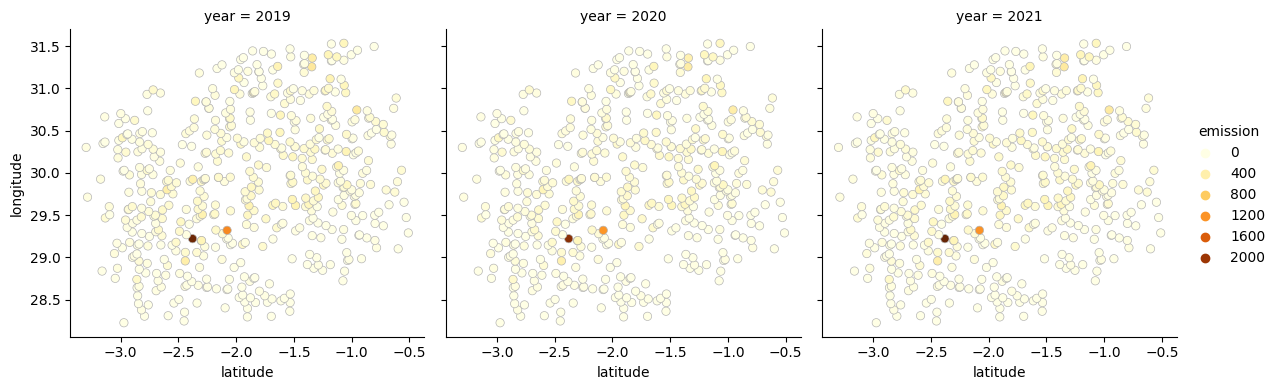

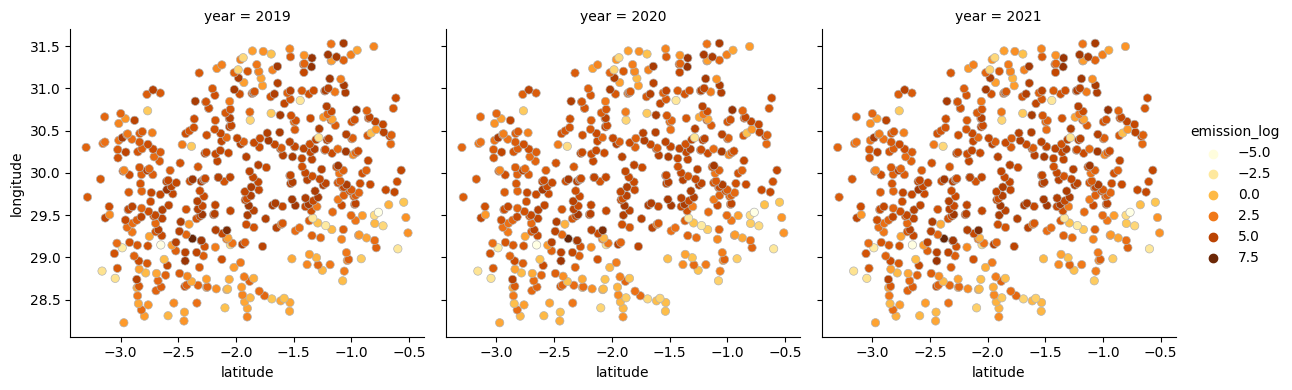

In [8]:
mean_yearly_emissions_df = df.groupby(["longitude", "latitude", "year"])["emission"].mean().reset_index()

sns.relplot(
    data=mean_yearly_emissions_df,
    x="latitude", y="longitude", hue="emission",
    palette="YlOrBr", edgecolor=".7", height=4, col="year"
)
plt.show()

mean_yearly_emissions_log_df = df.groupby(["longitude", "latitude", "year"])["emission_log"].mean().reset_index()
sns.relplot(
    data=mean_yearly_emissions_log_df,
    x="latitude", y="longitude", hue="emission_log",
    palette="YlOrBr", edgecolor=".7",
    height=4, col="year"
)
plt.show()

## Time series

In [9]:
def q10(x):
    return x.quantile(0.1)

def q25(x):
    return x.quantile(0.25)

def q50(x):
    return x.quantile(0.5)

def q75(x):
    return x.quantile(0.75)

def q90(x):
    return x.quantile(0.9)

mean_emissions_df = df.groupby("date")["emission"].agg(Mean="mean", q_10=q10, q_25=q25, q_50=q50, q_75=q75, q_90=q90)
mean_emissions_df = mean_emissions_df.reset_index()
mean_emissions_df["year"] = mean_emissions_df['date'].dt.year 
mean_emissions_df["week"] = mean_emissions_df['date'].dt.isocalendar().week
mean_emissions_df.head()

,date,Mean,q_10,q_25,q_50,q_75,q_90,year,week
0,2018-12-31,76.739149,1.010258,9.756213,41.193130,96.653946,163.697564,2018,1
1,2019-01-07,82.376350,1.004544,9.947974,43.580956,105.469840,175.971772,2019,2
2,2019-01-14,86.008823,0.989036,10.263707,45.942554,110.093420,185.659272,2019,3
3,2019-01-21,87.903964,1.004204,10.442887,46.912636,112.765480,189.896292,2019,4
4,2019-01-28,89.595095,0.990952,10.481367,47.589570,114.985886,194.491130,2019,5


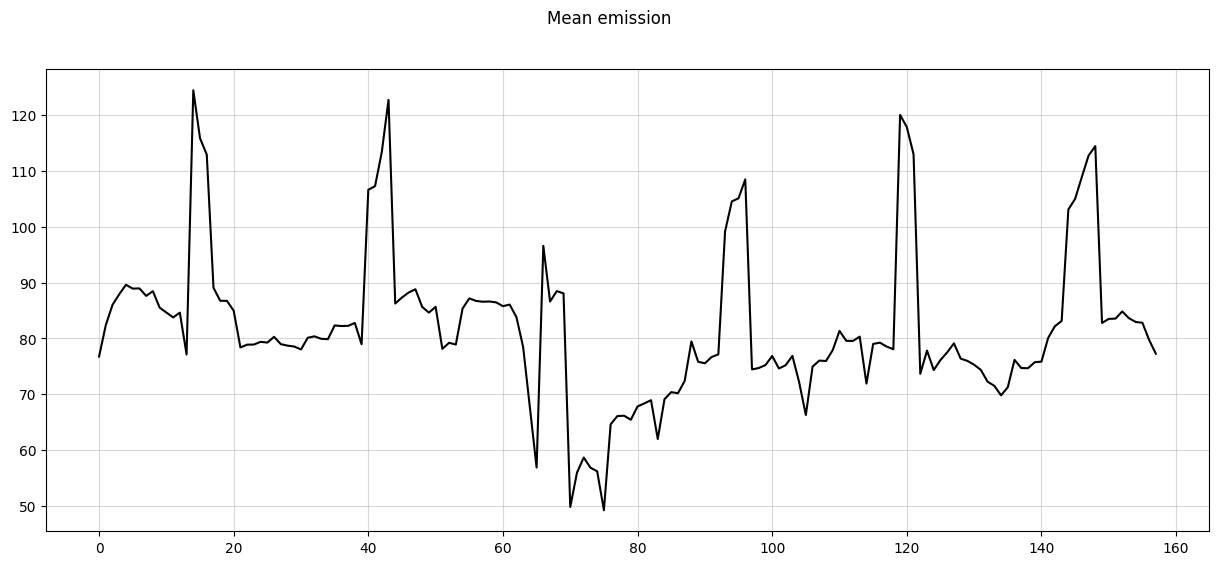

In [10]:
fig, ax = plt.subplots(1,1, figsize=(15, 6))
ax.plot(mean_emissions_df.index, mean_emissions_df["Mean"], color = "black")
ax.grid(alpha=0.5)
fig.suptitle("Mean emission")
fig.show()

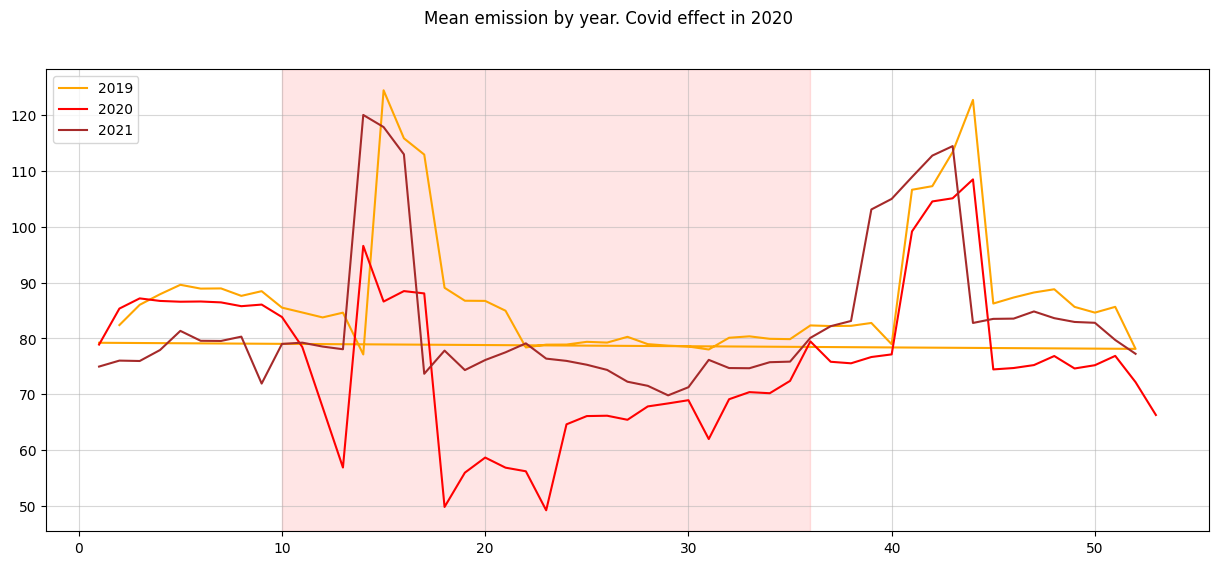

In [11]:
fig, ax = plt.subplots(1,1, figsize=(15, 6))
for year, color in zip([2019, 2020, 2021], ["orange", "red", "brown"]):
    tmp = mean_emissions_df[mean_emissions_df["year"] == year]
    ax.plot(tmp["week"], tmp["Mean"], color = color, label=year)
    
ax.axvspan(10, 36, color="red", alpha=0.1)
ax.legend(loc="upper left")
ax.grid(alpha=0.5)
fig.suptitle("Mean emission by year. Covid effect in 2020")
fig.show()

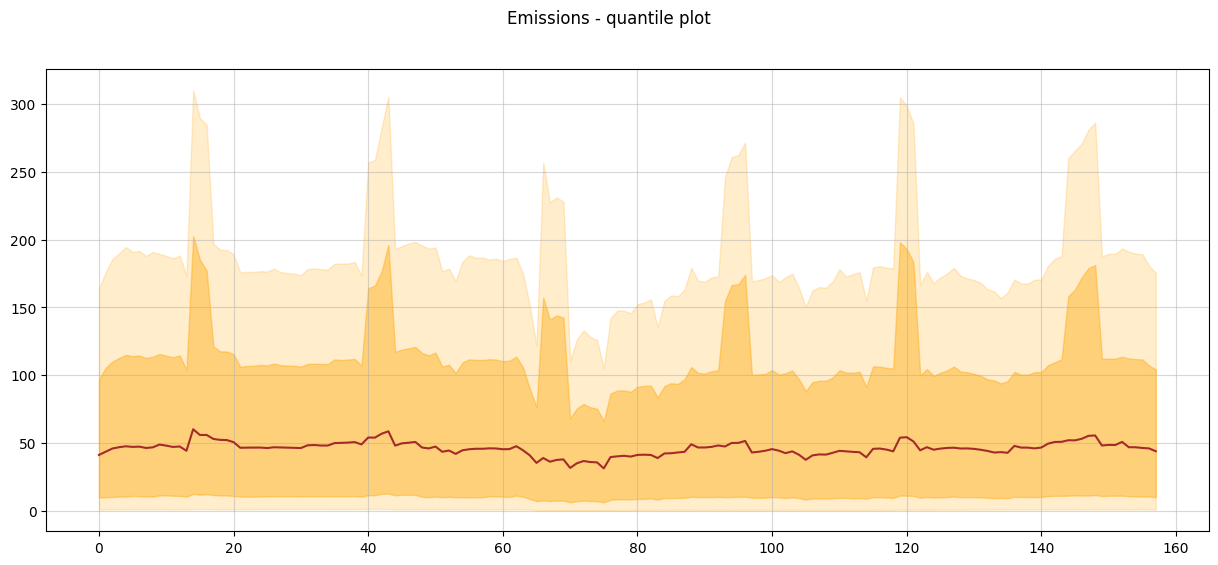

In [12]:
fig, ax = plt.subplots(1,1, figsize=(15, 6))
ax.plot(mean_emissions_df.index, mean_emissions_df["q_50"], color = "brown")
ax.fill_between(mean_emissions_df.index, mean_emissions_df['q_10'], mean_emissions_df['q_90'], color='orange', alpha=.2)
ax.fill_between(mean_emissions_df.index, mean_emissions_df['q_25'], mean_emissions_df['q_75'], color='orange', alpha=.4)
ax.grid(alpha=0.5)
fig.suptitle("Emissions - quantile plot")
fig.show()

# Correlations in the input data

In [13]:
df.set_index(["latitude", "longitude", "year", "week_no"], inplace=True)

regex_filter = re.compile('.*_(angle|altitude)$')
position_columns = [column for column in df.columns if regex_filter.match(column)]
print(f"\n\nColumns concerning sensor positions:\n{position_columns}")

value_columns = [column for column in df.columns if column not in position_columns]
value_columns = [col for col in value_columns if col not in ["date", "emission_log", "ID_LAT_LON_YEAR_WEEK"]]
print(f"\n\nColumns concerning sensor values:\n{value_columns}")



Columns concerning sensor positions:
['SulphurDioxide_sensor_azimuth_angle', 'SulphurDioxide_sensor_zenith_angle', 'SulphurDioxide_solar_azimuth_angle', 'SulphurDioxide_solar_zenith_angle', 'CarbonMonoxide_sensor_altitude', 'CarbonMonoxide_sensor_azimuth_angle', 'CarbonMonoxide_sensor_zenith_angle', 'CarbonMonoxide_solar_azimuth_angle', 'CarbonMonoxide_solar_zenith_angle', 'NitrogenDioxide_sensor_altitude', 'NitrogenDioxide_sensor_azimuth_angle', 'NitrogenDioxide_sensor_zenith_angle', 'NitrogenDioxide_solar_azimuth_angle', 'NitrogenDioxide_solar_zenith_angle', 'Formaldehyde_solar_zenith_angle', 'Formaldehyde_solar_azimuth_angle', 'Formaldehyde_sensor_zenith_angle', 'Formaldehyde_sensor_azimuth_angle', 'UvAerosolIndex_sensor_altitude', 'UvAerosolIndex_sensor_azimuth_angle', 'UvAerosolIndex_sensor_zenith_angle', 'UvAerosolIndex_solar_azimuth_angle', 'UvAerosolIndex_solar_zenith_angle', 'Ozone_sensor_azimuth_angle', 'Ozone_sensor_zenith_angle', 'Ozone_solar_azimuth_angle', 'Ozone_solar_

# Feature engineering

In [14]:
def show_correlations(columns, title = "Correlation Matrix"):
    if "emission" not in columns:
        columns.append("emission")
    tmp_df = df[columns]    
    f = plt.figure(figsize=(12, 14))
    plt.matshow(tmp_df.corr(), fignum=f.number, cmap="YlOrBr")
    plt.xticks(range(tmp_df.select_dtypes(['number']).shape[1]), columns, fontsize=14, rotation=85)
    plt.yticks(range(tmp_df.select_dtypes(['number']).shape[1]), columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title(title, fontsize=16);

### Correlations for sensor positions



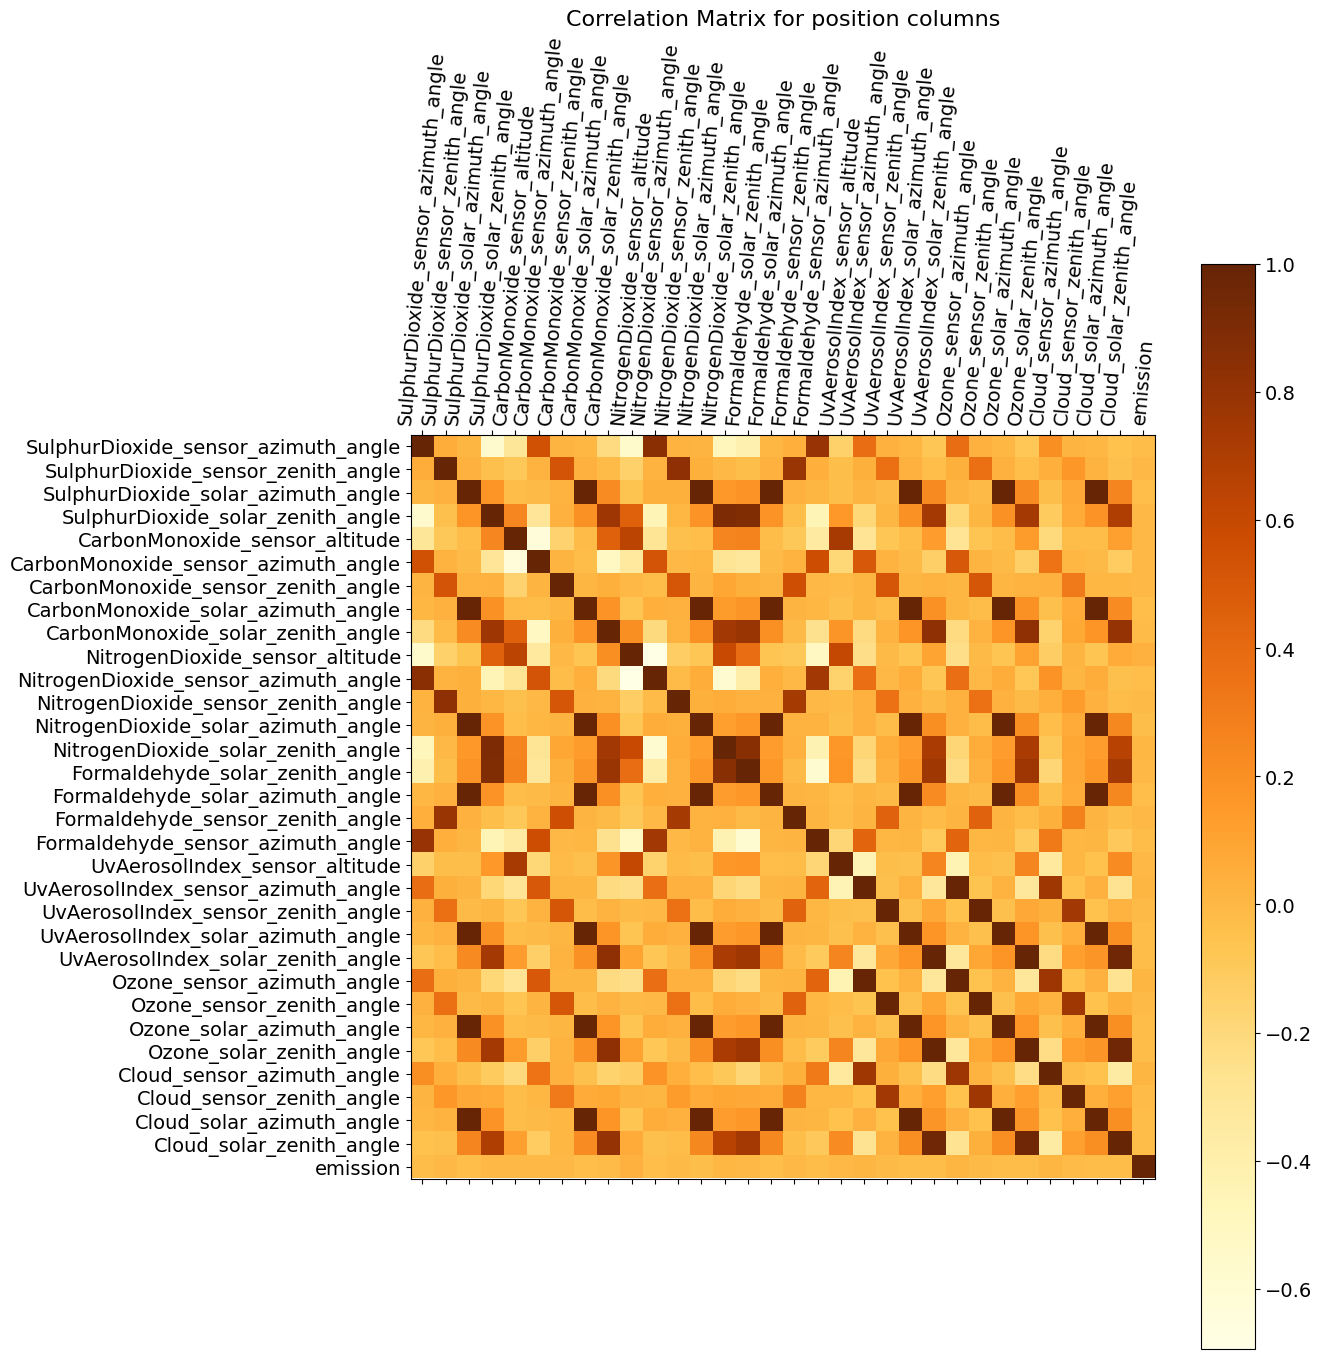

In [15]:
show_correlations(columns = position_columns, title='Correlation Matrix for position columns')

There are strong correlations between positions of SulphurDioxide, CarbonMonooxide, NitrogenDioxide and Formalhyde sensors
and between positions of Ozone, Cloud and UvAerosol sensors.

Sensor positions for SulphurDioxide and Cloud Solar will be used as representtives of all the other sensor positions

### Correlations for sensor values


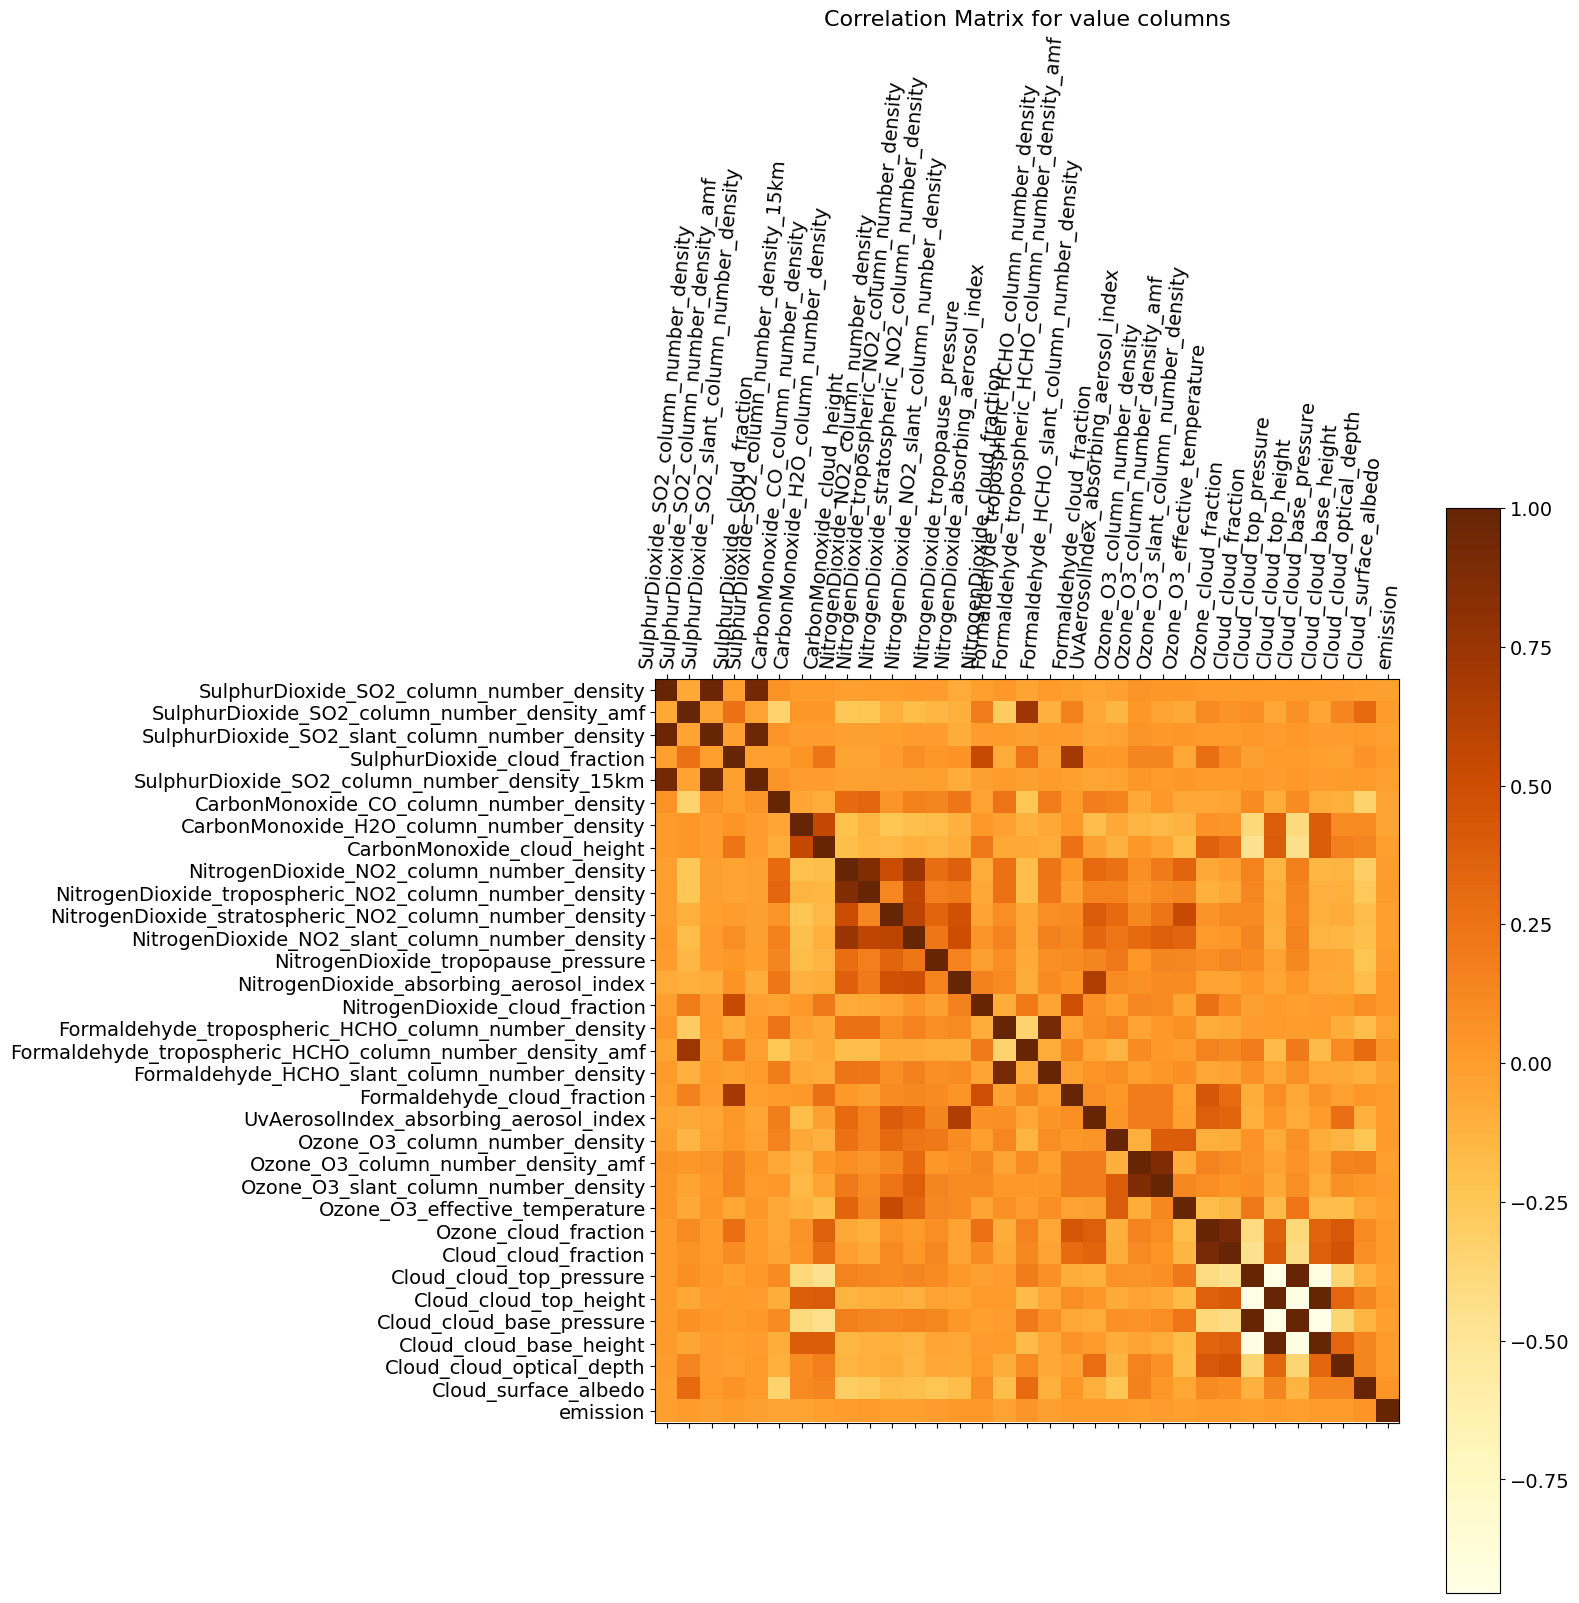

In [16]:
show_correlations(columns = value_columns, title='Correlation Matrix for value columns')

# Create time series dataset

In [17]:
df.reset_index(inplace=True)
df["relative_year"] = df["year"] - df["year"].min()
df["time_idx"] = df["relative_year"] * 53 + df["week_no"]
df.drop(['emission_log', 'date',"year"], axis=1, inplace=True)
df.fillna(0, inplace=True)
df.head()

,latitude,longitude,week_no,ID_LAT_LON_YEAR_WEEK,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,relative_year,time_idx
0,-0.51,29.29,0,ID_-0.510_29.290_2019_00,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,-130.050797,35.874496,-0.000027,0.035370,1589.024536,4061.098145,829530.500000,71.111977,52.775928,-149.875565,25.965214,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000117,0.863230,0.000038,0.255668,35.874496,-130.050797,50.843559,-98.593887,-1.280761,829864.546875,-12.628979,35.632416,-138.786446,30.752128,0.115927,2.506609,0.295663,225.731144,0.595473,-12.628979,35.632416,-138.786446,30.752128,0.595473,53534.732422,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994,0,0
1,-0.51,29.29,1,ID_-0.510_29.290_2019_01,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,-140.874435,28.965133,0.000012,0.036526,1772.574405,1869.040414,829787.287130,-1.019594,38.982368,-140.158048,29.562000,0.000047,1.639765e-05,0.00003,0.000093,7311.869141,-1.935386,0.067038,829859.960368,5.471037,35.265195,-138.343908,30.054262,0.000170,1.172826,0.000143,0.200754,29.071781,-141.814827,43.050213,4.678839,-1.548119,829747.856973,16.152492,43.485327,-142.786141,28.573627,0.116775,2.657704,0.315733,226.172170,0.175166,24.464335,42.596541,-143.097868,28.213655,0.213608,63790.296241,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176,0,1
2,-0.51,29.29,2,ID_-0.510_29.290_2019_02,0.000514,0.748199,0.000385,0.110018,72.795837,52.868816,-150.191757,23.206415,0.000154,0.035338,2703.236800,2809.138386,829883.828686,-54.801144,52.344378,-133.683714,31.586838,0.000031,4.267369e-07,0.00003,0.000080,7311.869141,-2.754374,0.072135,829527.125000,72.795837,52.868816,-150.191757,23.206415

In [18]:
time_varying_known_reals = value_columns + ["week_no", "relative_year"] 
time_varying_known_reals += ['CarbonMonoxide_sensor_altitude', 'CarbonMonoxide_sensor_altitude', 
                            'CarbonMonoxide_sensor_azimuth_angle', 'CarbonMonoxide_sensor_zenith_angle',
                            'CarbonMonoxide_solar_azimuth_angle', 'CarbonMonoxide_solar_zenith_angle',
                            'Cloud_sensor_azimuth_angle', 'Cloud_sensor_zenith_angle', 
                            'Cloud_solar_azimuth_angle', 'Cloud_solar_zenith_angle'
                           ]
time_varying_known_reals.remove("emission")
time_varying_known_reals

['SulphurDioxide_SO2_column_number_density',
 'SulphurDioxide_SO2_column_number_density_amf',
 'SulphurDioxide_SO2_slant_column_number_density',
 'SulphurDioxide_cloud_fraction',
 'SulphurDioxide_SO2_column_number_density_15km',
 'CarbonMonoxide_CO_column_number_density',
 'CarbonMonoxide_H2O_column_number_density',
 'CarbonMonoxide_cloud_height',
 'NitrogenDioxide_NO2_column_number_density',
 'NitrogenDioxide_tropospheric_NO2_column_number_density',
 'NitrogenDioxide_stratospheric_NO2_column_number_density',
 'NitrogenDioxide_NO2_slant_column_number_density',
 'NitrogenDioxide_tropopause_pressure',
 'NitrogenDioxide_absorbing_aerosol_index',
 'NitrogenDioxide_cloud_fraction',
 'Formaldehyde_tropospheric_HCHO_column_number_density',
 'Formaldehyde_tropospheric_HCHO_column_number_density_amf',
 'Formaldehyde_HCHO_slant_column_number_density',
 'Formaldehyde_cloud_fraction',
 'UvAerosolIndex_absorbing_aerosol_index',
 'Ozone_O3_column_number_density',
 'Ozone_O3_column_number_density_amf

In [19]:
max_pred_len = 25
max_encoder_len = 28
batch_size = 128
max_epochs = 50

training_cutoff = df["time_idx"].max() - max_pred_len

training = TimeSeriesDataSet(
            df[lambda x: x.time_idx <= training_cutoff],
            time_idx="time_idx",
            target="emission",
            group_ids = ["latitude", "longitude"],
            #static_reals=["latitude", "longitude"],
            time_varying_known_reals= time_varying_known_reals, 
            time_varying_unknown_reals=["emission"],
            min_encoder_length=max_encoder_len // 2,
            max_encoder_length=max_encoder_len,
            min_prediction_length=1,
            max_prediction_length=max_pred_len,
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
            allow_missing_timesteps=False,
            target_normalizer=GroupNormalizer(
                groups=["latitude", "longitude"], transformation="softplus"),  
        )

# create validation set that aims to predict the last max_encoder_len points for each time series
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# create dataloaders for model
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=1)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=1)

# Find the best hyperparameters

In [ ]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=100,
    max_epochs=max_epochs,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(4, 20),
    hidden_continuous_size_range=(4, 20),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30, accelerator="cpu"),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=True,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

# Train the model

In [20]:
mae_loss = MAE()
rmse_loss = RMSE()
res_dict = dict()

def evaluate(name, model, verbose = False):
    predictions = model.predict(val_dataloader, return_y=True)
    mae = float(mae_loss(predictions.output, predictions.y))
    rmse = float(rmse_loss(predictions.output, predictions.y))
    res_dict[name] = {"mae": mae, "rmse": rmse}
    if verbose:
        print(f"MAE Loss: {mae}")
        print(f"RMSE Loss: {rmse}")

        

In [21]:
def train_tft_model(train_dataloader, val_dataloader, 
                      max_epochs: int,
                      gradient_clip_val: float,
                      hidden_size: int,
                      hidden_continuous_size: int,
                      attention_head_size: int,
                      learning_rate: float, 
                      dropout: float = 0.0,
                      accelerator: str = "auto",
                     ):
    
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator=accelerator,
        enable_model_summary=True,
        gradient_clip_val=gradient_clip_val,
        callbacks=[early_stop_callback],
        limit_train_batches=128,
        enable_checkpointing=True,
    )

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=learning_rate,
        hidden_size=hidden_size,
        hidden_continuous_size=hidden_continuous_size,
        attention_head_size=attention_head_size,
        dropout=dropout,
        loss=QuantileLoss(),
        log_interval=-1,
        optimizer="Ranger",
        reduce_on_plateau_patience=4,
    )
    
    
    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    
    predictions = tft.predict(val_dataloader, return_y=True)
    mae = float(mae_loss(predictions.output, predictions.y))
    rmse = float(rmse_loss(predictions.output, predictions.y))
    print(f"MAE Loss: {mae}")
    print(f"RMSE Loss: {rmse}")
        
    return tft, trainer


In [22]:
hparams = {'gradient_clip_val': 0.15158498773539547, 'hidden_size': 19, 'dropout': 0.10101924778902521,
           'hidden_continuous_size': 5, 'attention_head_size': 3, 'learning_rate': 0.005011872336272722}


model_1, trainer = train_tft_model(train_dataloader, val_dataloader, accelerator = "gpu",
                                   max_epochs=max_epochs, **hparams)
best_model_path = trainer.checkpoint_callback.best_model_path
best_model_1 = TemporalFusionTransformer.load_from_checkpoint(best_model_path)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 480   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.3 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 24.7 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 24.2 K
7  | static_context_variable_selection  | GatedResid

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE Loss: 8.208379745483398
RMSE Loss: 24.01420783996582


# Predict on test dataset

In [24]:
columns = ['time_idx','emission','latitude', 'longitude', "relative_year", "week_no",
           'SulphurDioxide_SO2_column_number_density', 
           'SulphurDioxide_SO2_column_number_density_amf', 'SulphurDioxide_SO2_slant_column_number_density', 
           'SulphurDioxide_cloud_fraction', 'SulphurDioxide_SO2_column_number_density_15km',
           'CarbonMonoxide_CO_column_number_density', 'CarbonMonoxide_H2O_column_number_density', 
           'CarbonMonoxide_cloud_height', 'NitrogenDioxide_NO2_column_number_density',
           'NitrogenDioxide_tropospheric_NO2_column_number_density', 'NitrogenDioxide_stratospheric_NO2_column_number_density', 
           'NitrogenDioxide_NO2_slant_column_number_density', 'NitrogenDioxide_tropopause_pressure', 
           'NitrogenDioxide_absorbing_aerosol_index', 'NitrogenDioxide_cloud_fraction', 
           'Formaldehyde_tropospheric_HCHO_column_number_density', 'Formaldehyde_tropospheric_HCHO_column_number_density_amf', 
           'Formaldehyde_HCHO_slant_column_number_density', 'Formaldehyde_cloud_fraction', 
           'UvAerosolIndex_absorbing_aerosol_index', 'Ozone_O3_column_number_density',
           'Ozone_O3_column_number_density_amf', 'Ozone_O3_slant_column_number_density', 
           'Ozone_O3_effective_temperature', 'Ozone_cloud_fraction', 
           'Cloud_cloud_fraction', 'Cloud_cloud_top_pressure', 'Cloud_cloud_top_height', 'Cloud_cloud_base_pressure', 'Cloud_cloud_base_height', 'Cloud_cloud_optical_depth', 'Cloud_surface_albedo', 'relative_year', 'time_idx', 'week_no', 'year', 'CarbonMonoxide_sensor_altitude', 'CarbonMonoxide_sensor_altitude', 'CarbonMonoxide_sensor_azimuth_angle', 'CarbonMonoxide_sensor_zenith_angle', 'CarbonMonoxide_solar_azimuth_angle', 'CarbonMonoxide_solar_zenith_angle', 'Cloud_sensor_azimuth_angle', 'Cloud_sensor_zenith_angle', 
           'Cloud_solar_azimuth_angle', 'Cloud_solar_zenith_angle'  
]

columns = list(set(columns))

In [25]:
def predict_new_data(model, past_data):

    last_time_idx = past_data["time_idx"].max()

    # The testing data consists of records from the first 49 weeks of 2022 for 487 different localizations
    test_df = pd.read_csv("data/test.csv")    
    
    test_df["relative_year"] = test_df["year"] - 2019
    test_df["time_idx"] = test_df["relative_year"] * 53 + test_df["week_no"]
    
    test_df = test_df[test_df["time_idx"]> last_time_idx]
    test_df = pd.concat([past_data, test_df])
    test_df = test_df.sort_values(["latitude", "longitude", "time_idx"]).reset_index(drop=True)
    
    # fill emission values with the last known value, fill all the other values with 0
    test_df["emission"].fillna(method='ffill', inplace=True)
    test_df.fillna(0, inplace=True)
    

    # time idx for predictions
    new_time_idx =[last_time_idx + 1 + i for i in range(max_pred_len)]

    # predictions on test data
    raw_predictions = model.predict(pd.DataFrame(test_df[columns]), mode="prediction", return_x=False, return_index=True)
    predictions_df = raw_predictions.index.drop("time_idx", axis=1)
    predictions_df["predictions"] = raw_predictions.output.tolist()
    predictions_df = predictions_df.explode("predictions")
    predictions_df["time_idx"] = new_time_idx * n_locations
    
    # emissions can not be negative
    predictions_df.loc[predictions_df["predictions"] < 0, "predictions"] = 0
    
    predictions_df = pd.merge(test_df.drop("emission", axis=1), predictions_df, 
                              left_on=["latitude", "longitude", "time_idx"], 
                              right_on=["latitude", "longitude", "time_idx"])
    return predictions_df


In [26]:
# predict the first 25 days

past_data = df[df["time_idx"] > df["time_idx"].max()-max_pred_len]
predictions_df_1 = predict_new_data(model=model_1, past_data=past_data)
predictions_df_1 = predictions_df_1[['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'week_no', "time_idx", "predictions"]]
predictions_df_1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


,ID_LAT_LON_YEAR_WEEK,latitude,longitude,week_no,time_idx,predictions
0,ID_-3.299_30.301_2022_00,-3.299,30.301,0,159,26.341228
1,ID_-3.299_30.301_2022_01,-3.299,30.301,1,160,25.927849
2,ID_-3.299_30.301_2022_02,-3.299,30.301,2,161,26.06937
3,ID_-3.299_30.301_2022_03,-3.299,30.301,3,162,26.121956
4,ID_-3.299_30.301_2022_04,-3.299,30.301,4,163,25.619814
...,...,...,...,...,...,...
12420,ID_-0.510_29.290_2022_20,-0.510,29.290,20,179,4.165598
12421,ID_-0.510_29.290_2022_21,-0.510,29.290,21,180,4.235737
12422,ID_-0.510_29.290_2022_22,-0.510,29.290,22,181,4.194744
12423,ID_-0.510_29.290_2022_23,-0.510,29.290,23,182,4.15917


In [28]:
# predict the next 25 days

past_data = predictions_df_1.rename(columns={"predictions": "emission"})
predictions_df_2 = predict_new_data(model=model_1, past_data=past_data)
predictions_df_2 = predictions_df_2[['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'week_no', "time_idx", "predictions"]]
predictions_df_2

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


,ID_LAT_LON_YEAR_WEEK,latitude,longitude,week_no,time_idx,predictions
0,ID_-3.299_30.301_2022_25,-3.299,30.301,25,184,29.429367
1,ID_-3.299_30.301_2022_26,-3.299,30.301,26,185,27.951399
2,ID_-3.299_30.301_2022_27,-3.299,30.301,27,186,27.287394
3,ID_-3.299_30.301_2022_28,-3.299,30.301,28,187,28.115665
4,ID_-3.299_30.301_2022_29,-3.299,30.301,29,188,27.624371
...,...,...,...,...,...,...
11923,ID_-0.510_29.290_2022_44,-0.510,29.290,44,203,4.328502
11924,ID_-0.510_29.290_2022_45,-0.510,29.290,45,204,4.244552
11925,ID_-0.510_29.290_2022_46,-0.510,29.290,46,205,4.306211
11926,ID_-0.510_29.290_2022_47,-0.510,29.290,47,206,4.273757


# Final result

In [35]:
final_predictions = pd.concat([predictions_df_1, predictions_df_2]).rename(columns={"predictions": "emission"})
final_predictions[["ID_LAT_LON_YEAR_WEEK", "emission"]].to_csv('data/submission.csv', index=False)
final_predictions.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,week_no,time_idx,emission
0,ID_-3.299_30.301_2022_00,-3.299,30.301,0,159,26.341228
1,ID_-3.299_30.301_2022_01,-3.299,30.301,1,160,25.927849
2,ID_-3.299_30.301_2022_02,-3.299,30.301,2,161,26.06937
3,ID_-3.299_30.301_2022_03,-3.299,30.301,3,162,26.121956
4,ID_-3.299_30.301_2022_04,-3.299,30.301,4,163,25.619814


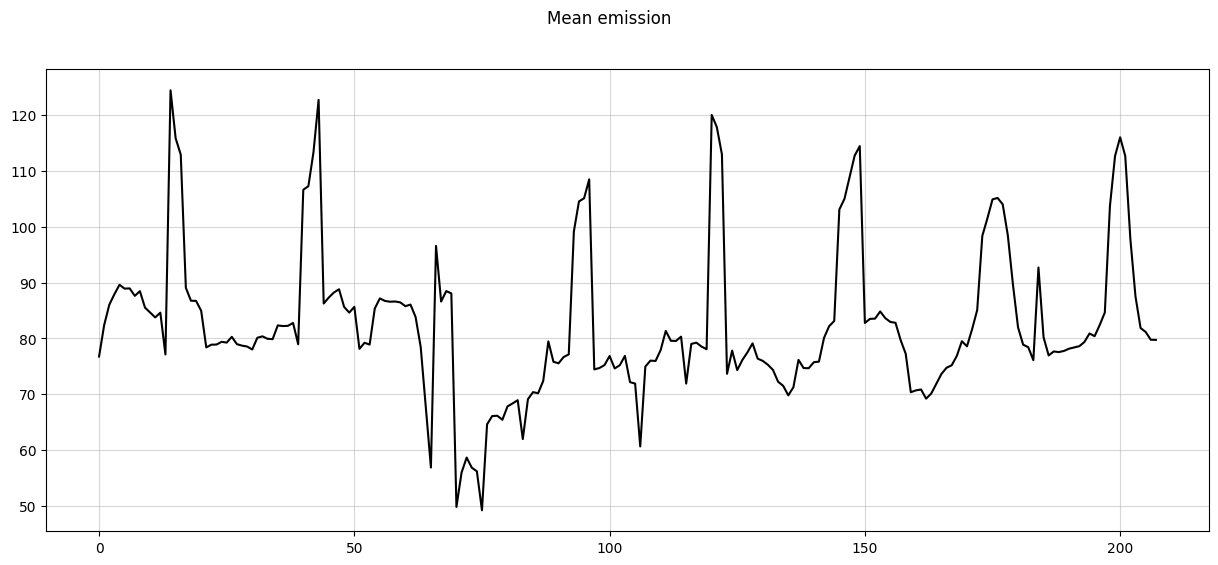

In [30]:
all_data = df[['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'week_no', "time_idx", "emission"]]
all_data = pd.concat([all_data, final_predictions])

mean_emissions_df = all_data.groupby("time_idx")["emission"].agg(Mean="mean")
mean_emissions_df = mean_emissions_df.reset_index()

fig, ax = plt.subplots(1,1, figsize=(15, 6))
ax.plot(mean_emissions_df.index, mean_emissions_df["Mean"], color = "black")
ax.grid(alpha=0.5)
fig.suptitle("Mean emission")
fig.show()